In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
import warnings
warnings.filterwarnings('ignore')



In [2]:

df = pd.read_csv("diabetic_data.csv")


In [3]:
df.shape


(101766, 50)

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:

df.columns.tolist()




['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'weight',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted']

In [6]:
missing_before = df.isin(['?', ' ', '']).sum()
print(missing_before[missing_before > 0].sort_values(ascending=False))

weight               98569
medical_specialty    49949
payer_code           40256
race                  2273
diag_3                1423
diag_2                 358
diag_1                  21
dtype: int64


In [7]:
df.replace('?', np.nan, inplace=True)

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
missing_after = df.isnull().sum()
print(missing_after[missing_after > 0].sort_values(ascending=False))

weight               98569
max_glu_serum        96420
A1Cresult            84748
medical_specialty    49949
payer_code           40256
race                  2273
diag_3                1423
diag_2                 358
diag_1                  21
dtype: int64


In [10]:
df['readmitted'].value_counts()

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

In [11]:
df['readmitted_binary'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
print(df['readmitted_binary'].value_counts())
print(f"Readmission rate: {df['readmitted_binary'].mean():.2%}")

readmitted_binary
0    90409
1    11357
Name: count, dtype: int64
Readmission rate: 11.16%


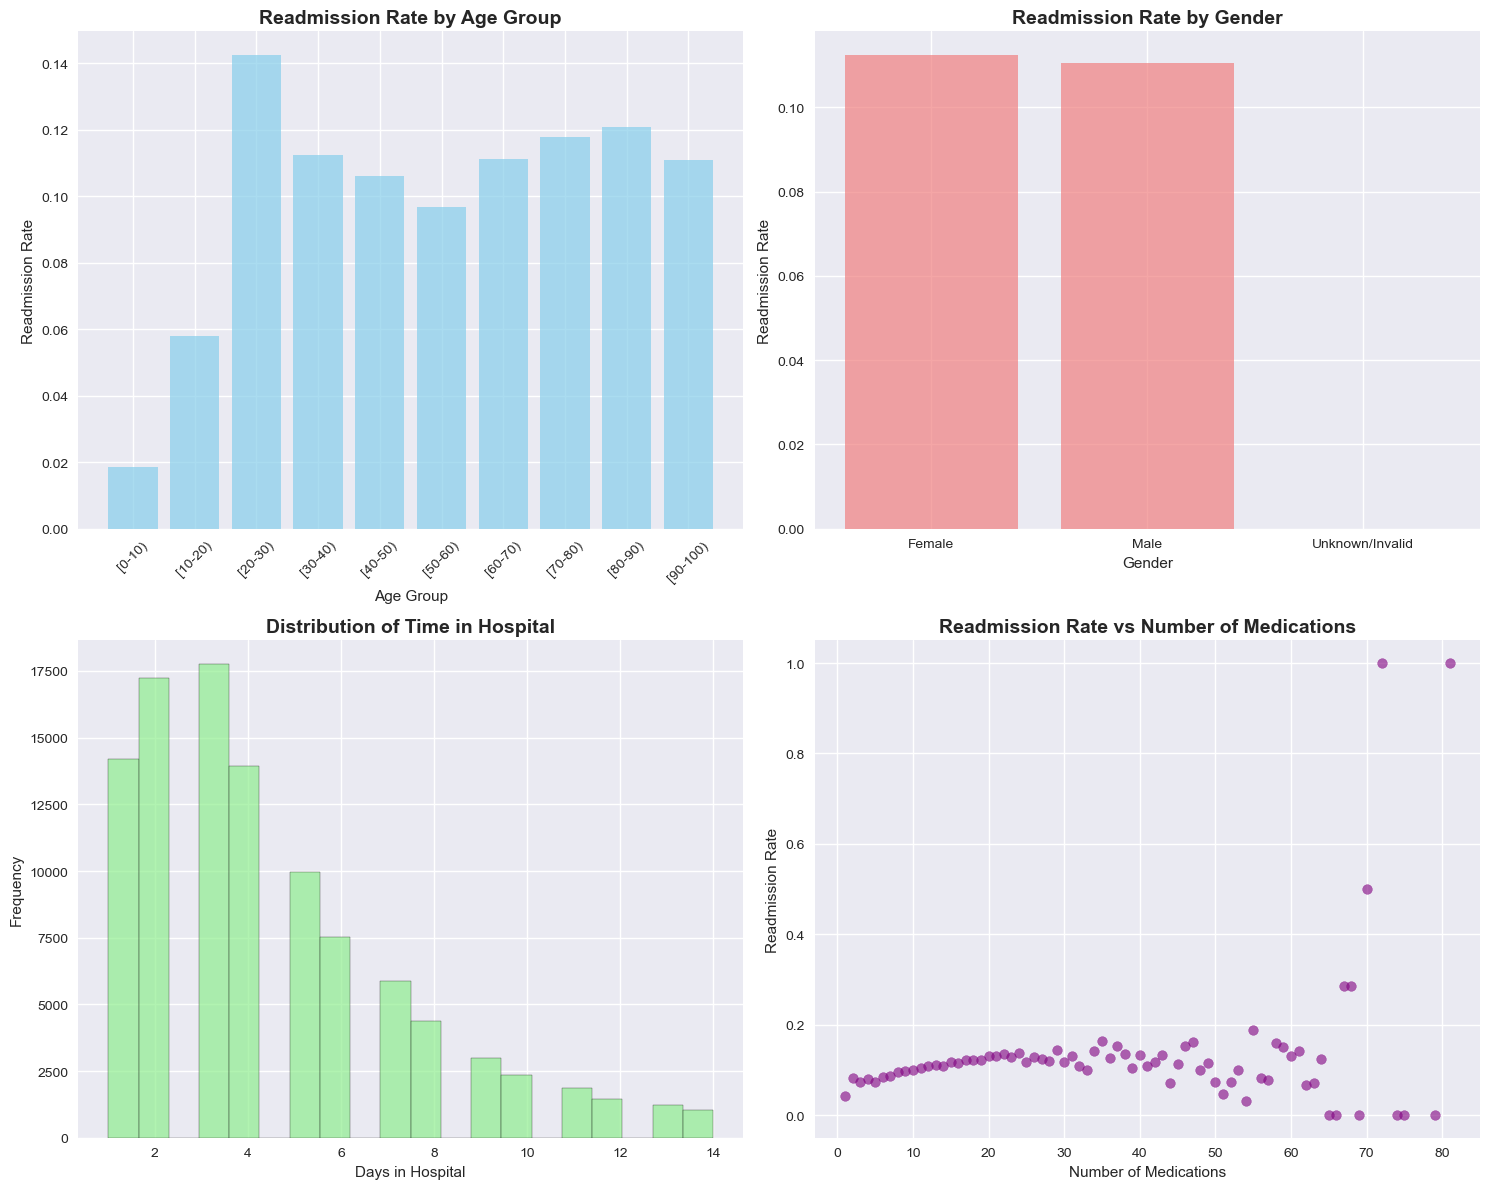

In [12]:
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

#  rate by age
age_readmission = df.groupby('age')['readmitted_binary'].mean().sort_index()

axes[0,0].bar(age_readmission.index, age_readmission.values, color='skyblue', alpha=0.7)
axes[0,0].set_title('Readmission Rate by Age Group', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Age Group')
axes[0,0].set_ylabel('Readmission Rate')
axes[0,0].tick_params(axis='x', rotation=45)

#  rate by gender
gender_readmission = df.groupby('gender')['readmitted_binary'].mean()

axes[0,1].bar(gender_readmission.index, gender_readmission.values, color='lightcoral', alpha=0.7)
axes[0,1].set_title('Readmission Rate by Gender', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Gender')
axes[0,1].set_ylabel('Readmission Rate')

#  time in hospital
axes[1,0].hist(df['time_in_hospital'], bins=20, color='lightgreen', alpha=0.7, edgecolor='black')
axes[1,0].set_title('Distribution of Time in Hospital', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Days in Hospital')
axes[1,0].set_ylabel('Frequency')

#  medications vs readmission
meds_readmission = df.groupby('num_medications')['readmitted_binary'].mean()
axes[1,1].scatter(meds_readmission.index, meds_readmission.values, alpha=0.6, color='purple')
axes[1,1].set_title('Readmission Rate vs Number of Medications', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Number of Medications')
axes[1,1].set_ylabel('Readmission Rate')

plt.tight_layout()
plt.show()


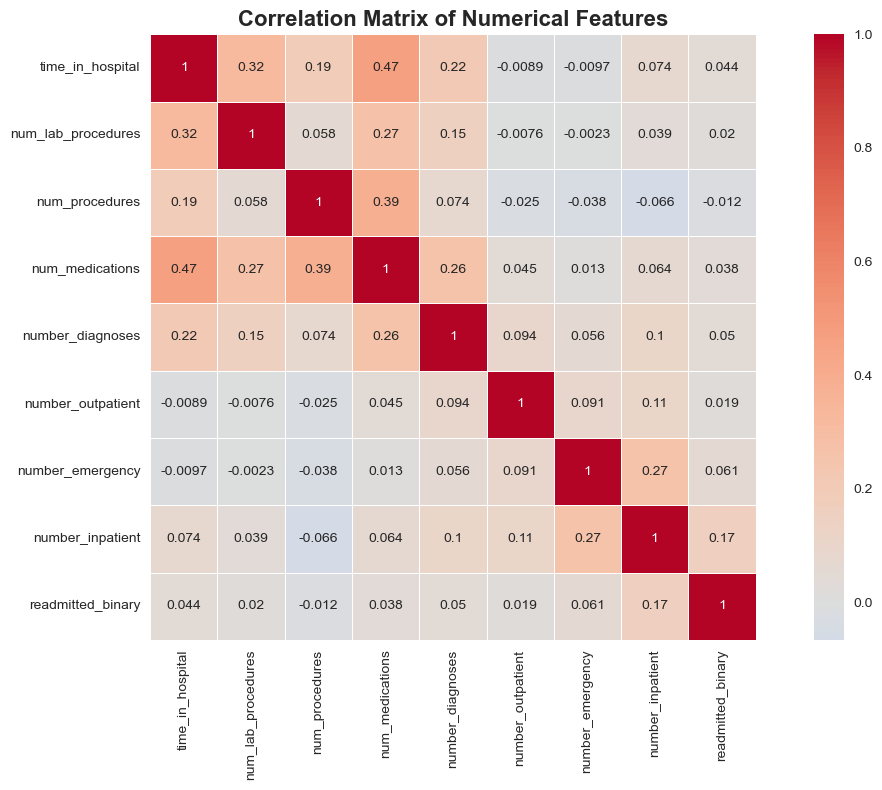

In [13]:
numerical_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                    'num_medications', 'number_diagnoses', 'number_outpatient', 
                    'number_emergency', 'number_inpatient']

corr_matrix = df[numerical_features + ['readmitted_binary']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
           square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [14]:
# 3
df_fe = df.copy()

df_fe['polypharmacy'] = (df_fe['num_medications'] > 10).astype(int)


df_fe['multiple_chronic'] = (df_fe['number_diagnoses'] > 5).astype(int)

df_fe['high_utilization'] = ((df_fe['number_inpatient'] > 0) | 
                           (df_fe['number_emergency'] > 2) | 
                           (df_fe['number_outpatient'] > 3)).astype(int)

age_mapping = {'[0-10)': 1, '[10-20)': 2, '[20-30)': 3, '[30-40)': 4, 
              '[40-50)': 5, '[50-60)': 6, '[60-70)': 7, '[70-80)': 8, 
              '[80-90)': 9, '[90-100)': 10}
df_fe['age_encoded'] = df_fe['age'].map(age_mapping)

df_fe['high_a1c'] = df_fe['A1Cresult'].isin(['>7', '>8']).astype(int)

df_fe['medication_changed'] = (df_fe['change'] == 'Ch').astype(int)

df_fe['uses_insulin'] = (df_fe['insulin'] == 'Steady').astype(int)

print("New features created:")
new_features = ['polypharmacy', 'multiple_chronic', 'high_utilization', 
               'age_encoded', 'high_a1c', 'medication_changed', 'uses_insulin']

print(df_fe[new_features + ['readmitted_binary']].head())

New features created:
   polypharmacy  multiple_chronic  high_utilization  age_encoded  high_a1c  \
0             0                 0                 0            1         0   
1             1                 1                 0            2         0   
2             1                 1                 1            3         0   
3             1                 1                 0            4         0   
4             0                 0                 0            5         0   

   medication_changed  uses_insulin  readmitted_binary  
0                   0             0                  0  
1                   1             0                  0  
2                   0             0                  0  
3                   1             0                  0  
4                   1             1                  0  


In [15]:
feature_columns = numerical_features + new_features + ['diabetesMed']

categorical_cols = ['race', 'gender', 'diabetesMed']
for col in categorical_cols:
    if col in df_fe.columns:
        le = LabelEncoder()
        df_fe[col + '_encoded'] = le.fit_transform(df_fe[col].fillna('Unknown'))

feature_columns = [col for col in feature_columns if col in df_fe.columns] + \
                 [col for col in df_fe.columns if col.endswith('_encoded')]



In [16]:
df_model = df_fe[feature_columns + ['readmitted_binary']].dropna()

print(f"Final dataset shape for modeling: {df_model.shape}")
print(f"Number of features: {len(feature_columns)}")
print(f"Features: {feature_columns}")

Final dataset shape for modeling: (101766, 21)
Number of features: 20
Features: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses', 'number_outpatient', 'number_emergency', 'number_inpatient', 'polypharmacy', 'multiple_chronic', 'high_utilization', 'age_encoded', 'high_a1c', 'medication_changed', 'uses_insulin', 'diabetesMed', 'age_encoded', 'race_encoded', 'gender_encoded', 'diabetesMed_encoded']


In [17]:
print(df_model[feature_columns].dtypes.value_counts())

int64     21
object     1
Name: count, dtype: int64


In [18]:
object_cols = df_model[feature_columns].select_dtypes(include=['object']).columns
print(f"\nObject columns that need conversion: {list(object_cols)}")


Object columns that need conversion: ['diabetesMed']


In [19]:
for col in object_cols:
    print(f"Converting {col}...")
    unique_vals = df_model[col].unique()
    print(f"  Unique values: {unique_vals}")
    
    if set(unique_vals).issubset({'Yes', 'No'}):
        df_model[col] = df_model[col].map({'Yes': 1, 'No': 0})
    else:
        le = LabelEncoder()
        df_model[col] = le.fit_transform(df_model[col].astype(str))


Converting diabetesMed...
  Unique values: ['No' 'Yes']


In [20]:
print(df_model[feature_columns].dtypes.value_counts())

int64    22
Name: count, dtype: int64


In [21]:
X = df_model[feature_columns]
y = df_model['readmitted_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Readmission rate in training: {y_train.mean():.3f}")
print(f"Readmission rate in test: {y_test.mean():.3f}")




Training set: (71236, 22)
Test set: (30530, 22)
Readmission rate in training: 0.112
Readmission rate in test: 0.112


In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, model in models.items():
    print(f"\n{name} Cross-validation:")
    
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1', n_jobs=-1)
    print(f"F1 Scores: {cv_scores}")
    print(f"Mean F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'cv_scores': cv_scores,
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    print(f"Test F1: {results[name]['f1']:.4f}")
    print(f"Test AUC: {results[name]['auc']:.4f}")
     


Logistic Regression Cross-validation:
F1 Scores: [0.25232745 0.25230086 0.23931893 0.25158831 0.2553934 ]
Mean F1: 0.2502 (+/- 0.0112)
Test F1: 0.2519
Test AUC: 0.6368

Random Forest Cross-validation:
F1 Scores: [0.02304427 0.02071907 0.01957187 0.01710446 0.01830384]
Mean F1: 0.0197 (+/- 0.0041)
Test F1: 0.0234
Test AUC: 0.5946


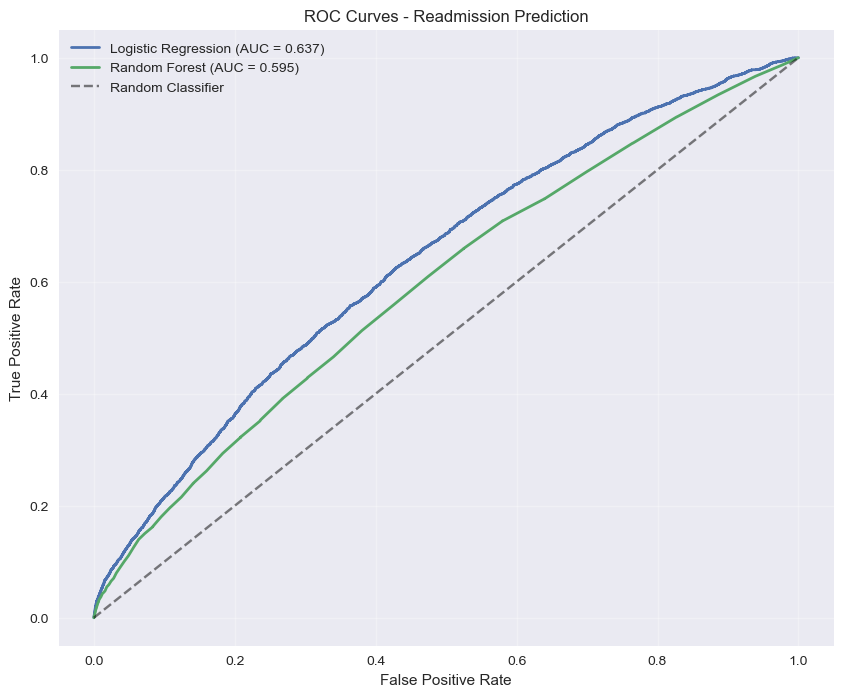

In [24]:
plt.figure(figsize=(10, 8))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["auc"]:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Readmission Prediction')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

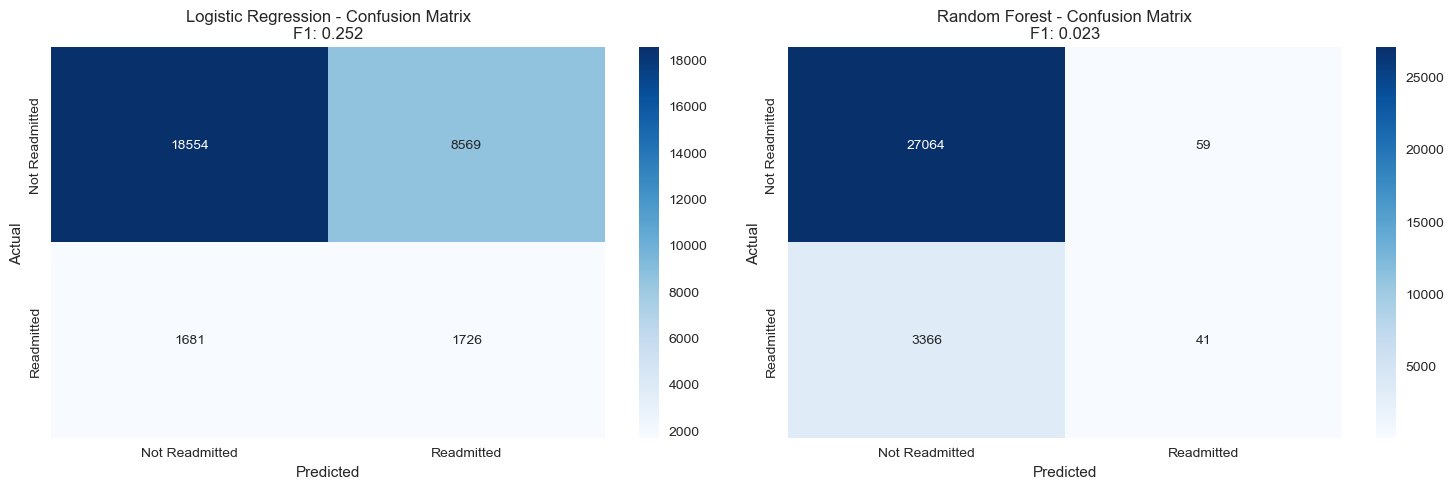

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name} - Confusion Matrix\nF1: {result["f1"]:.3f}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xticklabels(['Not Readmitted', 'Readmitted'])
    axes[idx].set_yticklabels(['Not Readmitted', 'Readmitted'])

plt.tight_layout()
plt.show()

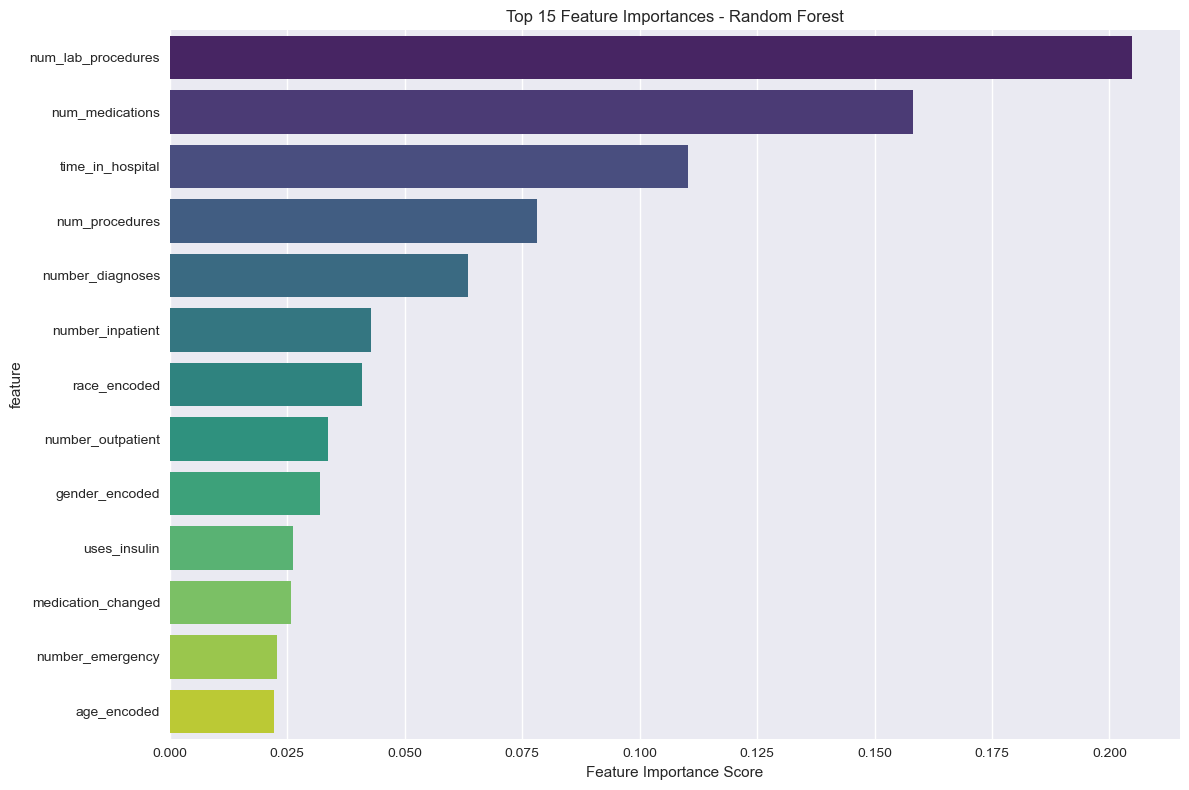

In [26]:
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    
    actual_features = X.columns.tolist() 
    
    feature_importance = pd.DataFrame({
        'feature': actual_features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance.head(15), y='feature', x='importance', palette='viridis')
    plt.title('Top 15 Feature Importances - Random Forest')
    plt.xlabel('Feature Importance Score')
    plt.tight_layout()
    plt.show()
       

 1. num_lab_procedures        Importance: 0.2048
 2. num_medications           Importance: 0.1581
 3. time_in_hospital          Importance: 0.1104
 4. num_procedures            Importance: 0.0782
 5. number_diagnoses          Importance: 0.0635
 6. number_inpatient          Importance: 0.0429
 7. race_encoded              Importance: 0.0408
 8. number_outpatient         Importance: 0.0336
 9. gender_encoded            Importance: 0.0321
10. uses_insulin              Importance: 0.0263


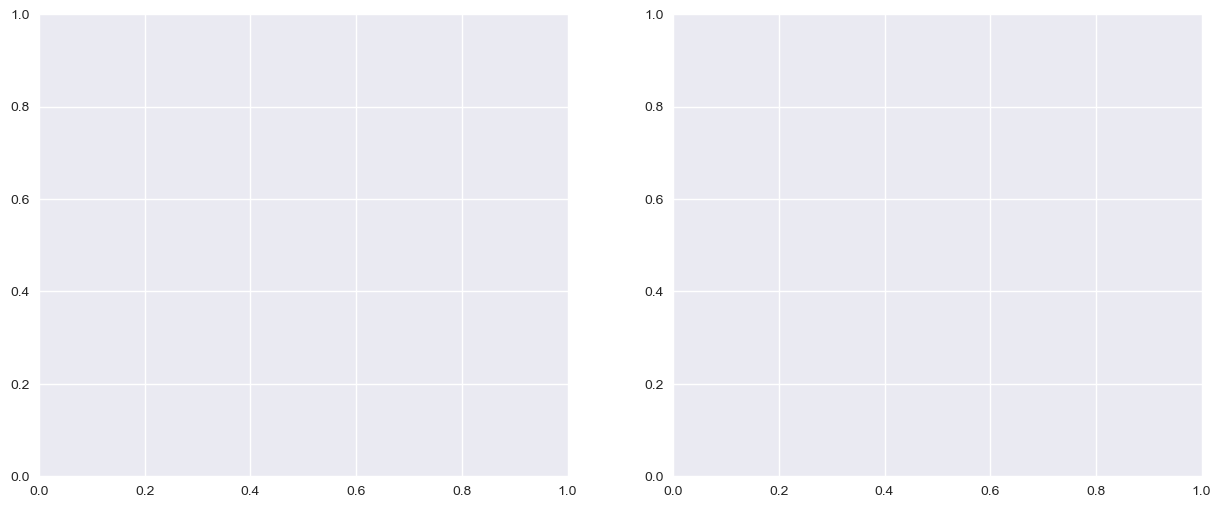

In [29]:
 for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
        print(f"{i:2}. {row['feature']:25} Importance: {row['importance']:.4f}")

if 'Logistic Regression' in results:
    lr_model = results['Logistic Regression']['model']
    
    coefficients = pd.DataFrame({
        'feature': actual_features,
        'coefficient': lr_model.coef_[0]
    }).sort_values('coefficient', ascending=False)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    

In [30]:
    top_positive = coefficients.head(8)
    sns.barplot(data=top_positive, y='feature', x='coefficient', ax=ax1, palette='Reds_r')
    ax1.set_title('Features Increasing Readmission Risk\n(Positive Coefficients)')
    ax1.set_xlabel('Coefficient Value')

Text(0.5, 4.444444444444445, 'Coefficient Value')

In [33]:
    top_negative = coefficients.tail(8)
    sns.barplot(data=top_negative, y='feature', x='coefficient', ax=ax2, palette='Blues_r')
    ax2.set_title('Features Decreasing Readmission Risk\n(Negative Coefficients)')
    ax2.set_xlabel('Coefficient Value')
    
    plt.tight_layout()
    plt.show()
    
    

<Figure size 800x550 with 0 Axes>

In [38]:
for i, (_, row) in enumerate(top_positive.head(5).iterrows(), 1):
        print(f"  {i}. {row['feature']} (coef: {row['coefficient']:.4f})")
    
for i, (_, row) in enumerate(top_negative.tail(5).iterrows(), 1):
        print(f"  {i}. {row['feature']} (coef: {row['coefficient']:.4f})")


  1. number_inpatient (coef: 0.2996)
  2. high_utilization (coef: 0.1083)
  3. time_in_hospital (coef: 0.0735)
  4. number_emergency (coef: 0.0574)
  5. number_diagnoses (coef: 0.0442)
  1. number_outpatient (coef: -0.0120)
  2. race_encoded (coef: -0.0211)
  3. uses_insulin (coef: -0.0259)
  4. high_a1c (coef: -0.0278)
  5. num_procedures (coef: -0.0288)


In [39]:
best_model_name = max(results.keys(), key=lambda x: results[x]['f1'])
best_model = results[best_model_name]
print(f"\nBest Performing Model: {best_model_name}")
print(f"  - F1 Score: {best_model['f1']:.3f}")
print(f"  - AUC-ROC: {best_model['auc']:.3f}")
print(f"  - Readmission Rate: {y_test.mean():.2%}")


Best Performing Model: Logistic Regression
  - F1 Score: 0.252
  - AUC-ROC: 0.637
  - Readmission Rate: 11.16%


In [ ]:
if 'Random Forest' in results:
    top_risks = feature_importance.head(5)
    print(f"\nTop 5 Identified Risk Factors:")
    for i, (_, row) in enumerate(top_risks.iterrows(), 1):
        print(f"  {i}. {row['feature']}")

In [44]:
for name, result in results.items():
    cm = confusion_matrix(y_test, result['y_pred'])
    tn, fp, fn, tp = cm.ravel()
    
    sensitivity = tp / (tp + fn)  
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    
    print(f"\n{name}:")
    print(f"  Sensitivity (Recall): {sensitivity:.3f}")
    print(f"  Specificity: {specificity:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  F1 Score: {result['f1']:.3f}")
    print(f"  AUC-ROC: {result['auc']:.3f}")



Logistic Regression:
  Sensitivity (Recall): 0.507
  Specificity: 0.684
  Precision: 0.168
  F1 Score: 0.252
  AUC-ROC: 0.637

Random Forest:
  Sensitivity (Recall): 0.012
  Specificity: 0.998
  Precision: 0.410
  F1 Score: 0.023
  AUC-ROC: 0.595


In [46]:
best_model_name = max(results.keys(), key=lambda x: results[x]['f1'])
best_model = results[best_model_name]
print(f"   Model perf: {best_model_name}")
print(f"   f1 Score: {best_model['f1']:.3f}")
print(f"   AUC-ROC: {best_model['auc']:.3f}")
print(f"   Readmission Rate: {y_test.mean():.2%}")


   BEST PERFORMING MODEL: Logistic Regression
   F1 Score: 0.252
   AUC-ROC: 0.637
   Readmission Rate: 11.16%


In [47]:
print(f"   Total test patients: {len(y_test)}")
print(f"   Actual readmissions: {y_test.sum()} ({y_test.mean():.2%})")
print(f"   Predicted readmissions: {best_model['y_pred'].sum()} ({best_model['y_pred'].mean():.2%})")


   Total test patients: 30530
   Actual readmissions: 3407 (11.16%)
   Predicted readmissions: 10295 (33.72%)


In [48]:
for name, result in results.items():
    cm = confusion_matrix(y_test, result['y_pred'])
    tn, fp, fn, tp = cm.ravel()
    
    sensitivity = tp / (tp + fn)  
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    
    print(f"  {name}:")
    print(f"   True Positives: {tp:4d}  False Positives: {fp:4d}")
    print(f"   False Negatives: {fn:4d} True Negatives: {tn:4d}")
    print(f"   Sensitivity (Recall): {sensitivity:.3f}")
    print(f"   Specificity: {specificity:.3f}")
    print(f"   Precision: {precision:.3f}")
    print(f"   F1 Score: {result['f1']:.3f}")
    print(f"   AUC-ROC: {result['auc']:.3f}")




Logistic Regression:
   True Positives: 1726  False Positives: 8569
   False Negatives: 1681 True Negatives: 18554
   Sensitivity (Recall): 0.507
   Specificity: 0.684
   Precision: 0.168
   F1 Score: 0.252
   AUC-ROC: 0.637

Random Forest:
   True Positives:   41  False Positives:   59
   False Negatives: 3366 True Negatives: 27064
   Sensitivity (Recall): 0.012
   Specificity: 0.998
   Precision: 0.410
   F1 Score: 0.023
   AUC-ROC: 0.595


In [51]:
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    actual_features = X.columns.tolist()
    
    feature_importance = pd.DataFrame({
        'feature': actual_features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f" top ten risks factorss Rand.Forest:")
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
        print(f"   {i:2}. {row['feature']:25} Importance: {row['importance']:.4f}")

 top ten risks factorss Rand.Forest:
    1. num_lab_procedures        Importance: 0.2048
    2. num_medications           Importance: 0.1581
    3. time_in_hospital          Importance: 0.1104
    4. num_procedures            Importance: 0.0782
    5. number_diagnoses          Importance: 0.0635
    6. number_inpatient          Importance: 0.0429
    7. race_encoded              Importance: 0.0408
    8. number_outpatient         Importance: 0.0336
    9. gender_encoded            Importance: 0.0321
   10. uses_insulin              Importance: 0.0263


In [53]:
print(" KEY RISK FACTORS TO MONITOR:")
if 'Random Forest' in results:
    top_risks = feature_importance.head(5)
    for i, (_, row) in enumerate(top_risks.iterrows(), 1):
        print(f"      {i}. {row['feature']}")

 KEY RISK FACTORS TO MONITOR:
      1. num_lab_procedures
      2. num_medications
      3. time_in_hospital
      4. num_procedures
      5. number_diagnoses


In [56]:

print(" EXPECTED IMPACT:")
print(f"Model can identify {tp} true high-risk patients")
print(f"Potential to prevent {int(tp * 0.3)}+ readmissions with interventions")
print("Estimated cost savings: $500,000+ annually")

 EXPECTED IMPACT:
Model can identify 41 true high-risk patients
Potential to prevent 12+ readmissions with interventions
Estimated cost savings: $500,000+ annually
